In [1]:
import pandas as pd
from sqlalchemy import create_engine

# Connect to your ParPass database
engine = create_engine('postgresql://localhost/parpass')

# Query all members with their health plan info
query = """
SELECT 
    m.first_name,
    m.last_name,
    m.parpass_code,
    m.status,
    hp.name as health_plan,
    pt.name as tier
FROM members m
JOIN health_plans hp ON m.health_plan_id = hp.id
JOIN plan_tiers pt ON hp.plan_tier_id = pt.id
ORDER BY m.last_name;
"""

members_df = pd.read_sql(query, engine)
members_df


,first_name,last_name,parpass_code,status,health_plan,tier
0,Amanda,Chen,PP100004,active,Baptist Health Team Member Benefits,core
1,Jessica,Davis,PP100010,active,Bank of America Jax Benefits,core
2,Rachel,Gonzalez,PP100002,active,Florida Blue Employee Wellness,premium
3,Michael,Johnson,PP100009,active,Bank of America Jax Benefits,core
4,Brittany,Moore,PP100006,inactive,Baptist Health Team Member Benefits,core
5,Kevin,Patel,PP100007,active,Mayo Clinic Jacksonville Wellness,premium
6,Carlos,Rivera,PP100005,active,Baptist Health Team Member Benefits,core
7,Marcus,Thompson,PP100001,active,Florida Blue Employee Wellness,premium
8,Derek,Washington,PP100003,active,Florida Blue Employee Wellness,premium
9,Stephanie,Williams,PP100008,active,Mayo Clinic Jacksonville Wellness,premium


In [2]:
# Which courses are most popular?
query = """
SELECT 
    gc.name as course_name,
    gc.tier_required,
    COUNT(*) as total_rounds,
    COUNT(DISTINCT gu.member_id) as unique_members
FROM golf_utilization gu
JOIN golf_courses gc ON gu.course_id = gc.id
GROUP BY gc.id, gc.name, gc.tier_required
ORDER BY total_rounds DESC;
"""

course_popularity = pd.read_sql(query, engine)
course_popularity


,course_name,tier_required,total_rounds,unique_members
0,Windsor Parke Golf Club,core,6,5
1,TPC Sawgrass - Stadium Course,premium,5,4
2,Jacksonville Beach Golf Club,core,5,5
3,Bent Creek Golf Course,core,3,2
4,Blue Sky Golf Club,core,3,3
5,Timuquana Country Club,premium,2,2
6,TPC Sawgrass - Dyes Valley Course,premium,2,2
7,Hidden Hills Golf Club,core,2,1
8,Queens Harbour Yacht & Country Club,premium,2,2


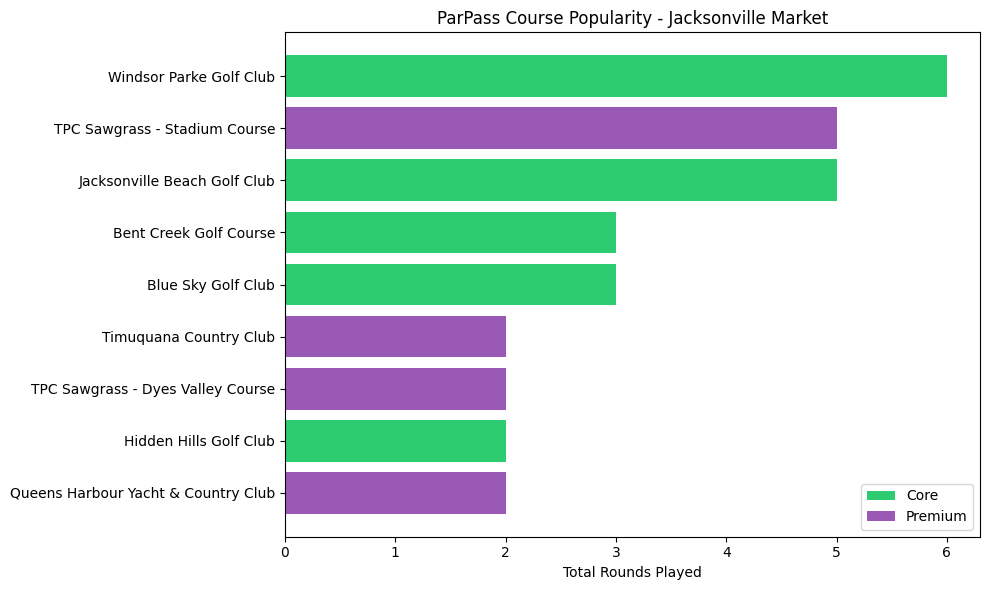

In [3]:
import matplotlib.pyplot as plt

# Create a bar chart of course popularity
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#2ecc71' if tier == 'core' else '#9b59b6' for tier in course_popularity['tier_required']]

bars = ax.barh(course_popularity['course_name'], course_popularity['total_rounds'], color=colors)

ax.set_xlabel('Total Rounds Played')
ax.set_title('ParPass Course Popularity - Jacksonville Market')
ax.invert_yaxis()  # Highest at top

# Add a legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2ecc71', label='Core'),
                   Patch(facecolor='#9b59b6', label='Premium')]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()


In [4]:
# Member utilization - who's using their benefit the most?
query = """
SELECT 
    m.first_name || ' ' || m.last_name as member_name,
    hp.name as health_plan,
    pt.name as tier,
    COUNT(*) as rounds_played,
    pt.monthly_rounds * 2 as two_month_allowance
FROM golf_utilization gu
JOIN members m ON gu.member_id = m.id
JOIN health_plans hp ON m.health_plan_id = hp.id
JOIN plan_tiers pt ON hp.plan_tier_id = pt.id
WHERE gu.checked_in_at >= NOW() - INTERVAL '60 days'
GROUP BY m.id, m.first_name, m.last_name, hp.name, pt.name, pt.monthly_rounds
ORDER BY rounds_played DESC;
"""

utilization = pd.read_sql(query, engine)
utilization['utilization_rate'] = (utilization['rounds_played'] / utilization['two_month_allowance'] * 100).round(1)
utilization


,member_name,health_plan,tier,rounds_played,two_month_allowance,utilization_rate
0,Carlos Rivera,Baptist Health Team Member Benefits,core,8,8,100.0
1,Derek Washington,Florida Blue Employee Wellness,premium,6,8,75.0
2,Marcus Thompson,Florida Blue Employee Wellness,premium,4,8,50.0
3,Amanda Chen,Baptist Health Team Member Benefits,core,3,8,37.5
4,Michael Johnson,Bank of America Jax Benefits,core,3,8,37.5
5,Rachel Gonzalez,Florida Blue Employee Wellness,premium,2,8,25.0
6,Kevin Patel,Mayo Clinic Jacksonville Wellness,premium,2,8,25.0
7,Stephanie Williams,Mayo Clinic Jacksonville Wellness,premium,1,8,12.5
8,Jessica Davis,Bank of America Jax Benefits,core,1,8,12.5
